# Prelude

Because of the IS-Academia website's *interesting* design choices, sacrificing a few goats to the deity of your choice may be required to fully understand this code.

In the immortal words of Dante Alighieri: **Lasciate ogni speranza, voi ch'entrate!**

# Fetching the data

First, let's import the libs we need.

In [2]:
# Usual stuff, as with previous homework
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

import requests # HTTP requests
from bs4 import BeautifulSoup # HTML parsing
import re # Regular expressions :(

And declare an useful type for students:

In [3]:
from collections import namedtuple

# For simplicity, we consider specializations to be a special case of minors
Student = namedtuple("Student", ["name", "gender", "minor"])

Then, let's get the index form, i.e. the base page we'll use to get all data:

In [8]:
# It's just an URL with a few weird symbols, how complex can it be?
index_url = "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter"

# ...requesting that doesn't return anything, turns out we need URL parameters.
# Surely it's simple and self-descriptive?
index_params = {
    # ...oh well...
    "ww_i_reportmodel": "133685247" 
}

def determine_content_parser(response):
    content_type = response.headers["Content-Type"]
    if ";" in content_type:
        content_type = content_type.split(";")[0]
    return content_type.split("/")[1]

def get_and_parse_url(url, params = []):
    resp = requests.get(url, params=params)
    if not resp.ok:
        raise Error("Unable to fecth page: " + resp.reason)
    return BeautifulSoup(resp.text, determine_content_parser(resp))

index_page = get_and_parse_url(index_url, index_params)

Then, fetch the page containing all of the "Informatique" (CS) links:

In [10]:
# Get the parameters for that page by fetching all of the "hidden" parameters, then adding our own to select CS.
info_index_params = dict([(i["name"], i["value"]) for i in index_page.findAll("input", attrs={"type": "hidden"})])

# Find the "HTML" option, get its value.
# Ideally we'd also find its name by looking for "HTML", but ISA doesn't use radiobuttons like normal people do,
# instead they have a button then some text right next to it, so looking for "html" will just find the text. :/
info_index_params["ww_i_reportModelXsl"] = index_page.find("input", attrs={"name": "ww_i_reportModelXsl"})["value"]

# Find the "Informatique" option, get its value
info_index_params["ww_x_UNITE_ACAD"] = index_page.find("option", text="Informatique")["value"]

info_index_page = get_and_parse_url(index_url, params=info_index_params)

Looking at the page in a browser, there are links.  
Have you ever heard of links? You define them with text, and an URL the user will go to if they click on the link.

...well, that's how normal people do links.  
IS-Academia does links that lead to nowhere, with JavaScript intercepting the click, creating an URL by manually scanning the user input on the page, setting a nested webpage's URL to that, and then reloading the page.

In [11]:
def find_semesters(name):
    """Find all semesters in Informatique matching the given regex."""
    semesters_by_id = []
    for link in info_index_page.findAll("a", attrs={"class": "ww_x_GPS"}):
        # Parse the link name, to find the year + semester
        link_name_match = re.search("Informatique, (\d+)-\d+, " + name, link.text)
        
        # Ignore weird stuff
        if link_name_match is None:
            continue
        
        # Find the link ID inside the onclick JavaScript.
        # ...
        # ...
        # ...why? just... why? why would anybody ever write a webpage like this?
        link_id_match = re.search(r"ww_x_GPS=(\d+)", link["onclick"])

        semesters_by_id.append((link_id_match.group(1), int(link_name_match.group(1))))
           
    # Now filter them to keep only 2007 and onwards.
    # Also remove those 2017 and later, since that hasn't happened yet so the data would be of dubious value.
    semesters_by_id = [v for v in semesters_by_id if 2007 <= v[1] <= 2016]

    # Are you scared yet? Now it gets worse!
    students_by_semester = []
    for semester in semesters_by_id:
        # For some reason the URL is now .html instead of .filter
        semester_url = "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html"
        
        # The parameters are the same as before, except now there's ww_x_GPS for the semester ID
        semester_params = info_index_params.copy()
        semester_params["ww_x_GPS"] = semester[0]
        
        semester_html = requests.get(semester_url, params=semester_params).text
        semester_page = BeautifulSoup(semester_html, "lxml")
        
        students = []
        # Iterate all rows, except the ones that have headers
        for row in semester_page.findAll("tr"):
            if row.contents[0].name != "th":
                # Just get the name!
                # It's the 2nd column. Can't be that hard.
                student_name = row.contents[1].text
                
                # ...oh wait. Instead of a normal space, it's a non-breaking space.
                # So let's replace that...
                student_name = student_name.replace("\xa0", " ")
                
                # Also, we need the gender
                student_gender = "M" if row.contents[0].text == "Monsieur" else "F"
                
                # And the minor/specialization for Masters students
                student_minor = row.contents[4].text # 4 = specialization
                if len(student_minor) == 0:
                    student_minor = row.contents[6].text # 6 = minor
                if len(student_minor) == 0:
                    student_minor = None
                
                students.append(Student(name=student_name, gender=student_gender, minor=student_minor))
        
        # Aaand we're done. Finally.
        students_by_semester.append((semester[1], students))
        
    return students_by_semester

Now that we can extract students by semester, we can do fun stuff!  
And by "fun stuff", I mean "what the homework asks for".

# Q1: Time to finish the Bachelor, by gender

So let's first find all students that were in Bachelor 1 and Bachelor 6 at some point.  
Also find the Bachelor 5, since at EPFL if you fail BA-6 and need to do an additional semester, you're back in BA-5.

In [18]:
students_ba1 = find_semesters("Bachelor semestre 1")
students_ba5 = find_semesters("Bachelor semestre 5")
students_ba6 = find_semesters("Bachelor semestre 6")

Then, make a Pandas frame from students who were in both, and the years they were in them, to get durations.

Note that the ISA data does not contain outcomes, i.e. students who failed their BA-6 and abandoned will get counted as having done their Bachelor in 3 years.

In [19]:
ba_students = []
known_students = set()

for students_by_year in students_ba1:
    begin_year = students_by_year[0]
    for student in students_by_year[1]:
        if student in known_students:
            # Student redoing their 1st year, ignore
            continue
        known_students.add(student)
        
        end_year = [sby[0] for sby in students_ba6 if student in sby[1]]
        if len(end_year) != 0:
            # Get the "real" end year, i.e. the last one the student was in.
            end_year = end_year[-1]
            
            # Now see if there's a later year in BA-5, i.e. the student did their bachelor in an odd # of semesters
            ba5_end_year = [sby[0] for sby in students_ba5 if student in sby[1]]
            
            duration = end_year - begin_year
            
            # Add either 0.5 or 1 depending on the last semester, e.g.
            # 2007 to 2009 spring -> 3
            # 2008 to 2011 fall -> 4.5
            # (we know the ba5 list has >=1 elem since the student was in BA-6 at some point)
            if ba5_end_year[-1] > end_year:
                if ba5_end_year[-1] == 2016:
                    # Ignore current students, can't know when they'll finish
                    continue
                    
                duration += 0.5
            else:
                duration += 1
            
            ba_students.append({
                "gender": student.gender,
                "duration": duration
            })

ba_students = pd.DataFrame(ba_students)

Compute fractions of students by duration and gender:

In [20]:
# Group the students
ba_groups = ba_students.groupby("duration")

# Helper method to get men/women from a frame
def of_gender(series, gender):
    return series[series["gender"] == gender]

# First, total sums: how many men and women?
ba_men = of_gender(ba_students, "M").size
ba_women = of_gender(ba_students, "F").size

# Then, fractions: what % of each gender took N years?
ba_frac_per_gender = []
for group in ba_groups:
    students = group[1]
    ba_frac_per_gender.append({
            "duration": group[0],
            "men": of_gender(students, "M").size / ba_men,
            "women": of_gender(students, "F").size / ba_women
        })

ba_frac_per_gender = pd.DataFrame(ba_frac_per_gender)
ba_frac_per_gender = ba_frac_per_gender.set_index(["duration"])

Then display and plot it, to get a good idea of what the data looks like:

In [17]:
ba_frac_per_gender.plot.bar()
ba_frac_per_gender

AttributeError: 'function' object has no attribute 'bar'

Now compute the average:

In [21]:
def show_student_info(gender):
    duration = of_gender(ba_students, gender)["duration"]
    print(gender + ": mean = " + str(round(duration.mean(),2)) + ", stdev = " + str(round(duration.std(), 2)))

show_student_info("M")
show_student_info("F")

M: mean = 3.39, stdev = 0.75
F: mean = 3.15, stdev = 0.39


Men take slightly longer to do their Bachelor, with a larger standard deviation as well.

However, there are very few women in CS bachelor, so the numbers may not mean that much:

In [22]:
print("Men: " + str(ba_men) + ", women: " + str(ba_women))

Men: 690, women: 52


We can confirm this hypothesis by adding two hypothetical female students that would take 7 years to do their bachelor, as much as the "worst" men. The average would then move by `2*(7-3.15)/(52+2) = 0.14`, which would move the female average to 3.39, matching men's.  
In other words, because there are so few women in CS bachelor ( :( ), the mean doesn't mean (ha!) much as even a tiny amount of outliers could shift it.

# Q2: Time to finish the Master, by minor/specialization

This time we're interested in Masters students.

We can just ignore the semester names and look at fall/spring only. This simplification takes care of edge cases such as people who choose to do their Masters in more than the usual number of semesters, people who fail classes and have to take more semesters, etc.

There does remain the fact that some people start their Masters in spring, though.

In [23]:
students_mafall_proj = find_semesters("Projet Master automne")
students_mafall = find_semesters("(Master semestre 1|Master semestre 3)") + students_mafall_proj
students_maspring_proj = find_semesters("Projet Master printemps")
students_maspring = find_semesters("Master semestre 2") + students_maspring_proj

# "spring 2008" means beginning of 2009,
# while "fall 2010" means end of 2010.
# We use fall as the reference point, so everything is shifted
students_maspring = [(sby[0] + 0.5, sby[1]) for sby in students_maspring]

Then, for each student, find their first and last years.

(this has horrible algorithmic complexity, but the number of semesters is small, so there's no point in optimizing it)

There is a catch, though: Most data on master projects is missing, so ignoring students without one would leave us with a tiny fraction of all students. Instead, assume that anybody with no information about a project succeeded at it in 1 semester.

In [24]:
# First get all students, it's simpler
students_ma_all = set()

for students_by_year in students_mafall:
    for student in students_by_year[1]:
        students_ma_all.add(student)
        
for students_by_year in students_maspring:
    for student in students_by_year[1]:
        students_ma_all.add(student)

# Get a list of students we do have project information about
students_ma_proj = students_mafall_proj + students_maspring_proj
students_ma_proj = sum((g[1] for g in students_ma_proj), [])
        
ma_students = []

for student in students_ma_all:
    # Simple logic for begin year
    begin_year_fall = next((sby[0] for sby in students_mafall if student in sby[1]), 9999)
    begin_year_spring = next((sby[0] for sby in students_maspring if student in sby[1]), 9999)
    begin_year = min(begin_year_fall, begin_year_spring)
    
    # Little more tricky for the end cause Python has no "last or default" operation
    end_year_fall = [sby[0] for sby in students_mafall if student in sby[1]]
    end_year_fall = end_year_fall[-1] if len(end_year_fall) > 0 else 0 
    end_year_spring = [sby[0] for sby in students_maspring if student in sby[1]]
    end_year_spring = end_year_spring[-1] if len(end_year_spring) > 0 else 0       
    end_year = max(end_year_fall, end_year_spring)
            
    if end_year >= 2016:
        # Ignore current students, we don't know when they'll finish
        continue
            
    # Add 0.5 since it's a range, but we want the inclusive time
    duration = end_year - begin_year + 0.5
    if duration <= 1:
        # Ignore students who appear to have finished in 1 year or less, that is not possible
        continue
        
    # Assume the student did their project in 1 semester if not specified
    if student not in students_ma_proj:
        duration += 0.5
        
    ma_students.append({
        "gender": student.gender,
        "minor": student.minor,
        "begin": begin_year,
        "duration": duration
    })

ma_students = pd.DataFrame(ma_students)
# Avoid having to special-case None later for minors
ma_students = ma_students.fillna("No minor")

In [25]:
# Group the students
ma_groups = ma_students.groupby("duration")

# Get all minors
ma_minors = set(ma_students["minor"])

# Helper method to get all students with the specified minor from a frame
def of_minor(series, minor):
    return series[series["minor"] == minor]

# What % of each minor took N years?
ma_frac_per_minor = []
for group in ma_groups:
    students = group[1]
    
    results = {}
    results["duration"] = group[0]
    
    for minor in ma_minors:
        minor_size = of_minor(ma_students, minor).size
        results[minor] = of_minor(students, minor).size / minor_size
    
    ma_frac_per_minor.append(results)

ma_frac_per_minor = pd.DataFrame(ma_frac_per_minor)
ma_frac_per_minor = ma_frac_per_minor.set_index(["duration"])

We can then display the fraction of each minor that spent a certain number of years to get their degree.

No plot this time, there are so many minors it's really messy.

In [26]:
ma_frac_per_minor

,Area and Cultural Studies minor,Biocomputing,Computer Engineering - SP,Foundations of Software,Information security minor,Internet computing,Mineur en Biocomputing,Mineur en Etudes asiatiques contemporaines,Mineur en Ingénierie financière,"Mineur en Management, technologie et entrepreneuriat",Mineur en Mathématiques,Mineur en Technologies spatiales,No minor,Service science,"Signals, Images and Interfaces",Software Systems
duration,,,,,,,,,,,,,,,,
1.5,0,0,0.00,0.032258,0,0.023256,0.000000,0,0.0,0.058824,0.0,0,0.063241,0,0.000000,0.00
2.0,1,1,0.75,0.612903,1,0.674419,0.857143,1,0.4,0.647059,0.5,0,0.675889,1,0.250000,0.75
2.5,0,0,0.25,0.193548,0,0.255814,0.000000,0,0.4,0.117647,0.5,1,0.217391,0,0.416667,0.25
3.0,0,0,0.00,0.161290,0,0.023256,0.142857,0,0.2,0.117647,0.0,0,0.031621,0,0.333333,0.00
3.5,0,0,0.00,0.000000,0,0.023256,0.000000,0,0.0,0.058824,0.0,0,0.007905,0,0.000000,0.00
4.0,0,0,0.00,0.000000,0,0.000000,0.000000,0,0.0,0.000000,0.0,0,0.003953,0,0.000000,0.00


And do some basic stats on them:

In [27]:
minor_analysis = []
for minor in ma_minors:
    duration = of_minor(ma_students, minor)["duration"]
    minor_analysis.append({
        "minor": minor,
        "mean": str(round(duration.mean(),2)),
        "stdev": str(round(duration.std(), 2))
    })
    
minor_analysis = pd.DataFrame(minor_analysis)
minor_analysis = minor_analysis.set_index(["minor"])
minor_analysis

,mean,stdev
minor,,
Area and Cultural Studies minor,2.0,0.0
"Signals, Images and Interfaces",2.54,0.4
Mineur en Ingénierie financière,2.4,0.42
Foundations of Software,2.24,0.41
Biocomputing,2.0,0.0
Mineur en Technologies spatiales,2.5,0.0
Computer Engineering - SP,2.12,0.25
Information security minor,2.0,0.0
Service science,2.0,0.0


The only minors that stand out are "Signals, Images and Interfaces" and "Mineur en Ingénierie financière".

In other words, hardware and finance people are crazy. No new information there. (dear peer reviewer: this is a joke :) )

# Q3: Time to finish Masters by gender over time

/usr/lib64/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


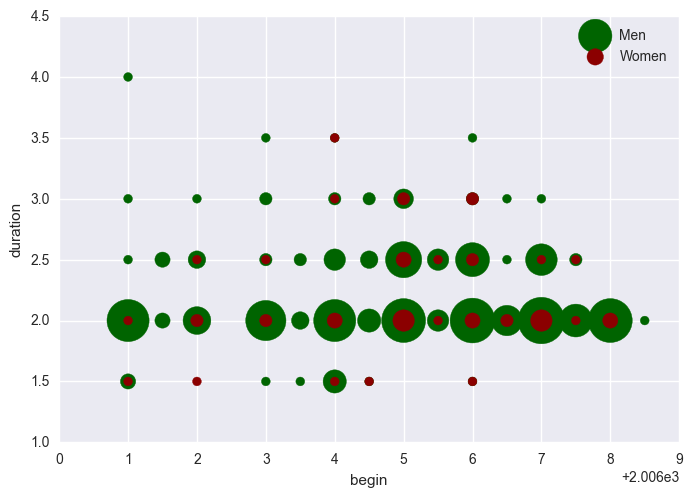

In [28]:
def plot_ma_time(students, label, color, ax):
    ma_counts = []
    for group in students.groupby(["begin", "duration"]):
        ma_counts.append({
            "begin": group[0][0],
            "duration": group[0][1],
            "count": group[1].size
        })

    ma_counts = pd.DataFrame(ma_counts)
    return ma_counts.plot(kind='scatter', label=label, color=color,
                          x='begin', y='duration', s=ma_counts["count"] * 10, ax=ax)

ax = plot_ma_time(ma_students[ma_students["gender"] == "M"], "Men", "DarkGreen", None)
plot_ma_time(ma_students[ma_students["gender"] == "F"], "Women", "DarkRed", ax)

This graph kind of look like olives. You know, the stuffed-with-peppers kind?

Anyway, one interesting observation is that there are more and more people starting their Masters in the spring semester. Or maybe ISA just doesn't have some old data?

Another observation: the number of people doing their Masters in exactly 3 semesters has gone down to 0 in recent years.